In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.utils import to_categorical

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Deep-learning/final project')

In [5]:
def plot_prediction(y_test, y_pred, title, r2, mse, scorr):
  plt.figure(figsize=(8, 8))
  sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
  plt.xlabel('True Values (y_test)')
  plt.ylabel('Predicted Values (y_pred)')
  plt.title(title)
  plt.grid(True)
  plt.figtext(0.75, 0.21, f'MSE: {mse:.3f}', horizontalalignment='left', fontsize=11)
  plt.figtext(0.75, 0.18, f'R\u00B2: {r2:.3f}', horizontalalignment='left', fontsize=11)
  plt.figtext(0.75, 0.15, f'Corr: {scorr:.3f}', horizontalalignment='left', fontsize=11)
  plt.show()

In [6]:
wt = pd.read_csv('WT/WT.csv')
wt.head()

,sgRNA,indel
0,AAAAAAAAACTCCAAAACCCTGG,0.168570
1,AAAAAACAACAAGAAGCACAAGG,0.099624
2,AAAAAACACAAGCAAGACCGTGG,0.247750
3,AAAAAACAGATGCCACCTGTGGG,0.141232
4,AAAAAACCCGTAGATAGCCTCGG,0.045803


In [7]:
sgRNA_split = wt['sgRNA'].apply(lambda x: list(x))
sgRNA_split = pd.DataFrame(sgRNA_split.tolist())
sgRNA_split.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,A,A,A,A,A,A,A,A,A,C,...,A,A,A,A,C,C,C,T,G,G
1,A,A,A,A,A,A,C,A,A,C,...,A,A,G,C,A,C,A,A,G,G
2,A,A,A,A,A,A,C,A,C,A,...,A,A,G,A,C,C,G,T,G,G
3,A,A,A,A,A,A,C,A,G,A,...,C,A,C,C,T,G,T,G,G,G
4,A,A,A,A,A,A,C,C,C,G,...,A,T,A,G,C,C,T,C,G,G


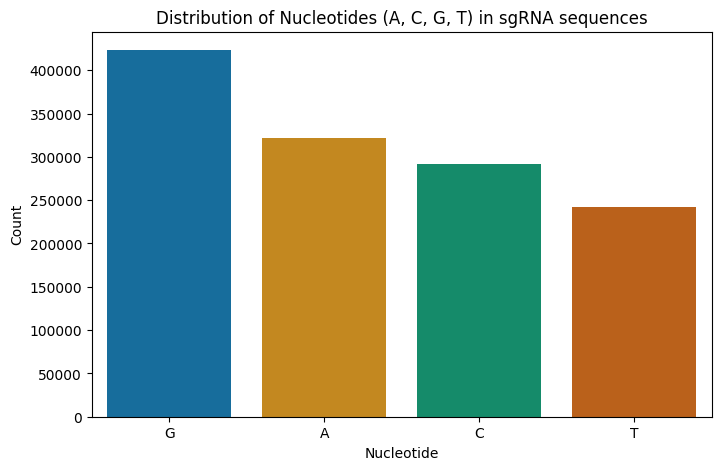

In [ ]:
nucleotide_counts = sgRNA_split.stack().value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=nucleotide_counts.index, y=nucleotide_counts.values, hue=nucleotide_counts.index, palette='colorblind', legend=False)
plt.title('Distribution of Nucleotides (A, C, G, T) in sgRNA sequences')
plt.xlabel('Nucleotide')
plt.ylabel('Count')
plt.show()

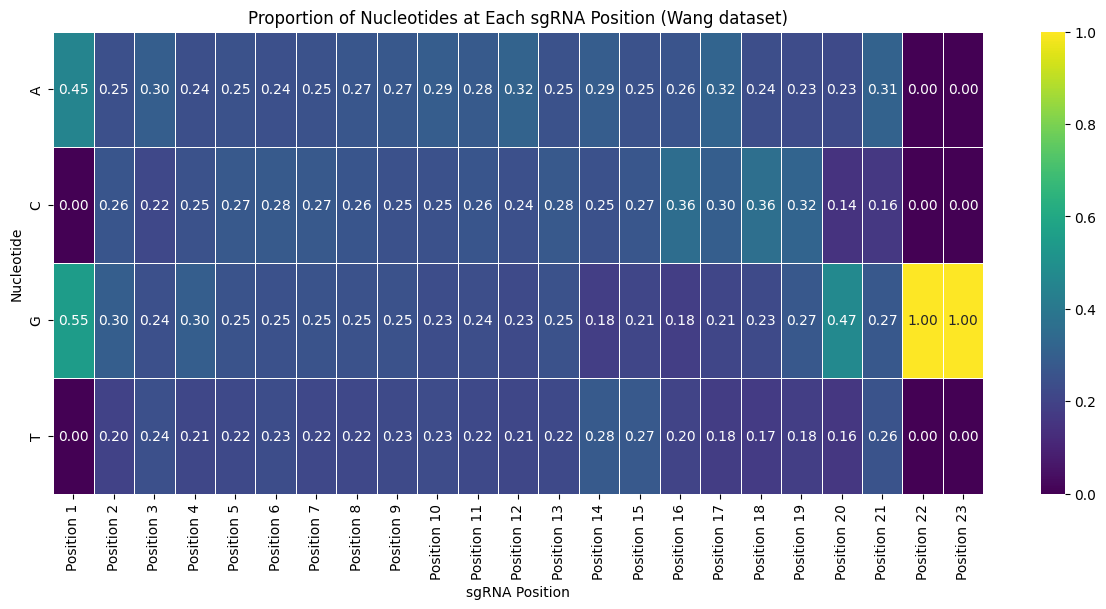

In [ ]:
nucleotide_proportions = pd.DataFrame()
all_nucleotides = ['A', 'C', 'G', 'T']

for col_name in sgRNA_split.columns:
    counts = sgRNA_split[col_name].value_counts(normalize=True)
    # Ensure all nucleotides are present, filling missing with 0
    counts = counts.reindex(all_nucleotides, fill_value=0)
    nucleotide_proportions[f'Position {col_name+1}'] = counts

plt.figure(figsize=(15, 6))
sns.heatmap(nucleotide_proportions, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Proportion of Nucleotides at Each sgRNA Position (Wang dataset)')
plt.xlabel('sgRNA Position')
plt.ylabel('Nucleotide')
plt.show()

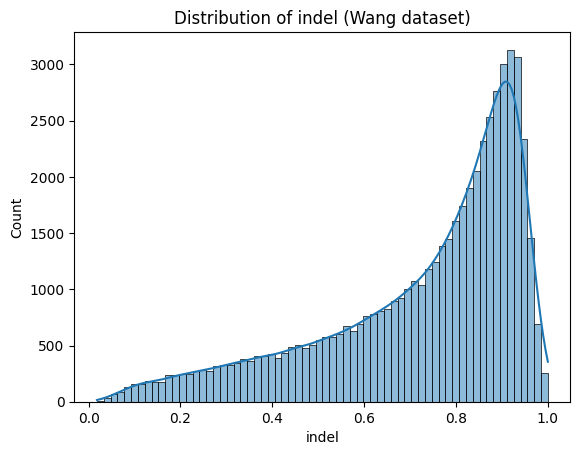

In [ ]:
sns.histplot(wt['indel'], kde=True)
plt.title('Distribution of indel (Wang dataset)')
plt.show()

In [8]:
from sklearn.preprocessing import LabelEncoder

sgRNA_split_encoded = sgRNA_split.copy()
label_encoders = {}

for col in sgRNA_split_encoded.columns:
    le = LabelEncoder()
    sgRNA_split_encoded[col] = le.fit_transform(sgRNA_split_encoded[col])
    label_encoders[col] = le

sgRNA_split_encoded = sgRNA_split_encoded.iloc[:, :-2] # Exclude the last two columns
sgRNA_split_encoded.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,0,1,1,1,3
1,0,0,0,0,0,0,1,0,0,1,...,0,2,0,0,2,1,0,1,0,0
2,0,0,0,0,0,0,1,0,1,0,...,2,1,0,0,2,0,1,1,2,3
3,0,0,0,0,0,0,1,0,2,0,...,2,1,1,0,1,1,3,2,3,2
4,0,0,0,0,0,0,1,1,1,2,...,0,2,0,3,0,2,1,1,3,1


In [9]:
sgRNA_label = pd.concat([wt.drop('sgRNA', axis=1), sgRNA_split_encoded], axis=1)
sgRNA_label.head()

,indel,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
0,0.168570,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,1,1,3
1,0.099624,0,0,0,0,0,0,1,0,0,...,0,2,0,0,2,1,0,1,0,0
2,0.247750,0,0,0,0,0,0,1,0,1,...,2,1,0,0,2,0,1,1,2,3
3,0.141232,0,0,0,0,0,0,1,0,2,...,2,1,1,0,1,1,3,2,3,2
4,0.045803,0,0,0,0,0,0,1,1,1,...,0,2,0,3,0,2,1,1,3,1


In [10]:
from sklearn.model_selection import train_test_split

X = sgRNA_label.drop('indel', axis=1)
y = sgRNA_label['indel']

y_binned = pd.cut(y, bins=10, labels=False, include_lowest=True)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_binned)

y_temp_binned = pd.cut(y_temp, bins=10, labels=False, include_lowest=True)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp_binned)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (44482, 21)
y_train shape: (44482,)
X_val shape: (5560, 21)
y_val shape: (5560,)
X_test shape: (5561, 21)
y_test shape: (5561,)


### Base model: Gradient boost regression

In [11]:
X_train_np = X_train.values
X_test_np = X_test.values

X_train_one_hot = to_categorical(X_train_np, num_classes=4)
X_test_one_hot = to_categorical(X_test_np, num_classes=4)

X_train_one_hot = X_train_one_hot.reshape(X_train_one_hot.shape[0], -1)
X_test_one_hot = X_test_one_hot.reshape(X_test_one_hot.shape[0], -1)

print(f'X_train_one_hot shape: {X_train_one_hot.shape}')
print(f'X_test_one_hot shape: {X_test_one_hot.shape}')

X_train_one_hot shape: (44482, 84)
X_test_one_hot shape: (5561, 84)


In [12]:
%%time
import xgboost as xgb
xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train_one_hot, y_train)

y_pred_xgb = xgb_model.predict(X_test_one_hot)

CPU times: user 3.17 s, sys: 46.7 ms, total: 3.21 s
Wall time: 1.97 s


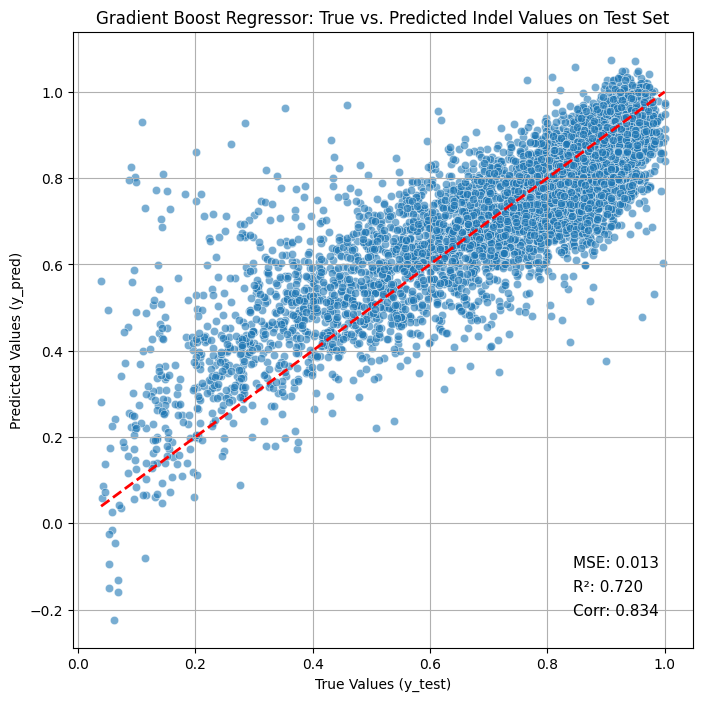

In [ ]:
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
scorr_xgb = spearmanr(y_test, y_pred_xgb).correlation

plot_prediction(y_test, y_pred_xgb, title='Gradient Boost Regressor: True vs. Predicted Indel Values on Test Set',
                r2=r2_xgb,mse=mse_xgb, scorr=scorr_xgb)

In [22]:
results_df = pd.DataFrame({'True_Value': y_test, 'Predicted_Value': y_pred_xgb}, index=y_test.index)

false_positive_data = results_df[
    (results_df['Predicted_Value'] > 0.6) &
    (results_df['True_Value'] < 0.4)
]

print(f"Number of data points where Predicted Value > 0.6 and True Value < 0.4: {len(false_positive_data)/len(y_test):.3f}")
print(false_positive_data.head())

Number of data points where Predicted Value > 0.6 and True Value < 0.4: 0.014
       True_Value  Predicted_Value
47133    0.393903         0.627495
31268    0.284127         0.667215
37780    0.152561         0.769611
8761     0.285496         0.662629
30991    0.372418         0.775643


In [13]:
sp = pd.read_csv('WT/SpCas9.csv')
sp_split = sp['sgRNA'].apply(lambda x: list(x))
sp_split = pd.DataFrame(sp_split.tolist())
sp_split.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,T,T,C,T,G,C,C,T,T,G,...,C,T,C,T,G,G,G,T,C,G
1,A,C,G,A,C,C,T,T,C,A,...,A,G,T,G,A,G,G,A,C,A
2,A,G,G,A,C,G,A,C,G,A,...,C,C,T,C,T,G,G,A,T,C
3,G,C,A,G,C,A,A,A,C,T,...,C,T,T,G,T,G,G,C,C,C
4,C,C,G,G,C,A,G,A,T,A,...,C,T,C,T,A,G,G,T,A,C


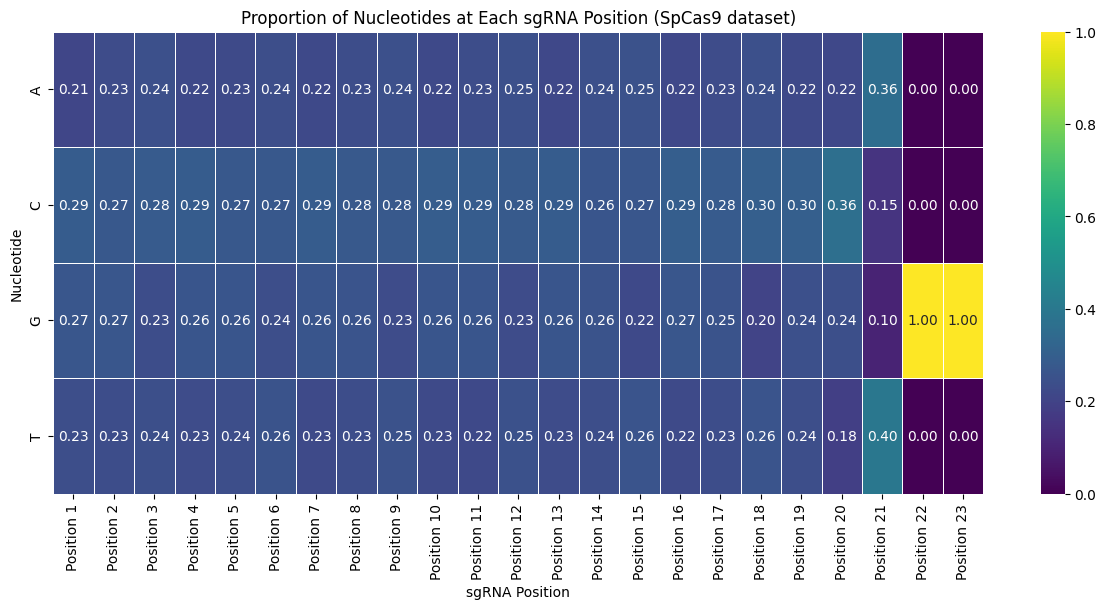

In [ ]:
nucleotide_proportions = pd.DataFrame()
all_nucleotides = ['A', 'C', 'G', 'T']

for col_name in sp_split.columns[4:27]:
    counts = sp_split[col_name].value_counts(normalize=True)
    counts = counts.reindex(all_nucleotides, fill_value=0)
    nucleotide_proportions[f'Position {col_name-3}'] = counts

plt.figure(figsize=(15, 6))
sns.heatmap(nucleotide_proportions, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Proportion of Nucleotides at Each sgRNA Position (SpCas9 dataset)')
plt.xlabel('sgRNA Position')
plt.ylabel('Nucleotide')
plt.show()

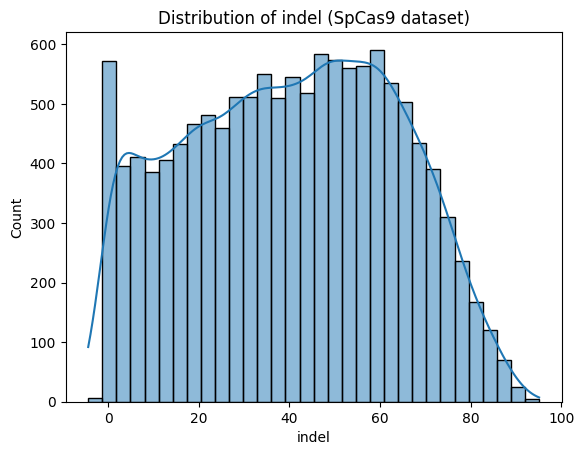

In [ ]:
sns.histplot(sp['indel'], kde=True)
plt.title('Distribution of indel (SpCas9 dataset)')
plt.show()

In [14]:
from sklearn.preprocessing import LabelEncoder

sp_split_encoded = sp_split.copy()
label_encoders = {}

for col in sp_split_encoded.columns:
    le = LabelEncoder()
    sp_split_encoded[col] = le.fit_transform(sp_split_encoded[col])
    label_encoders[col] = le

sp_split_encoded = sp_split_encoded.iloc[:, 4:25]
sp_split_encoded.head()

,4,5,6,7,8,9,10,11,12,13,...,15,16,17,18,19,20,21,22,23,24
0,2,1,1,3,3,2,3,3,3,1,...,3,3,1,1,3,1,3,1,3,2
1,1,1,3,3,1,0,2,1,3,1,...,2,3,2,0,1,0,2,3,2,0
2,1,2,0,1,2,0,1,3,0,1,...,0,3,0,0,2,1,1,3,1,3
3,1,0,0,0,1,3,2,0,1,2,...,0,2,0,0,1,1,3,3,2,3
4,1,0,2,0,3,0,3,1,1,2,...,2,0,0,2,2,1,3,1,3,0


In [17]:
sp_label = sp.drop('sgRNA', axis=1)/100
sp_label_np = np.array(sp_label).reshape(-1)
sp_label_np.shape

(12832,)

In [15]:
sp_encoded_np = sp_split_encoded.values

sp_label_one_hot = to_categorical(sp_encoded_np, num_classes=4)

sp_label_one_hot = sp_label_one_hot.reshape(sp_label_one_hot.shape[0], -1)

print(f'sp_label_one_hot shape: {sp_label_one_hot.shape}')

sp_label_one_hot shape: (12832, 84)


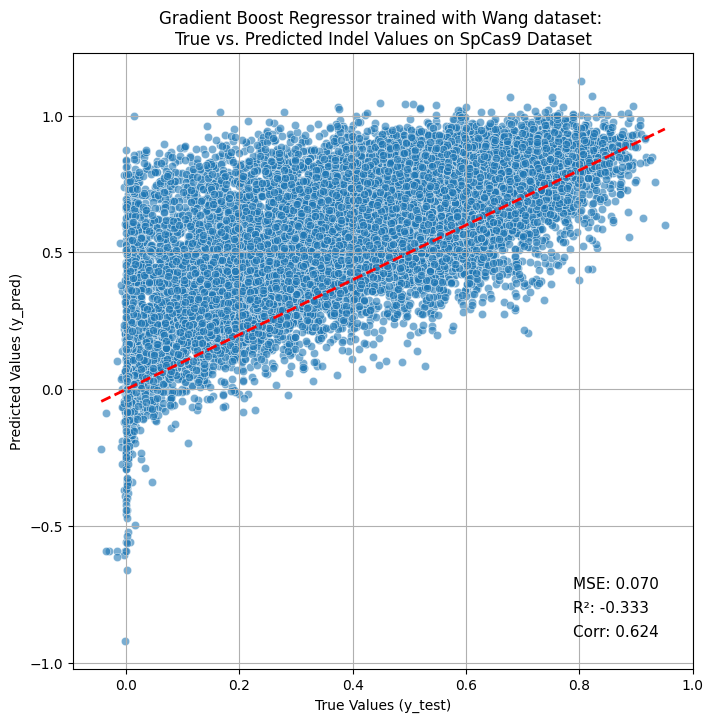

In [18]:
y_pred_sp = xgb_model.predict(sp_label_one_hot)
mse_xgb = mean_squared_error(sp_label_np, y_pred_sp)
r2_xgb = r2_score(sp_label_np, y_pred_sp)
scorr_xgb = spearmanr(sp_label_np, y_pred_sp).correlation

plot_prediction(sp_label_np, y_pred_sp, title='Gradient Boost Regressor trained with Wang dataset: \nTrue vs. Predicted Indel Values on SpCas9 Dataset',
                r2=r2_xgb,mse=mse_xgb, scorr=scorr_xgb)

In [21]:
results_df = pd.DataFrame({'True_Value': sp_label_np, 'Predicted_Value': y_pred_sp}, index=sp_label.index)

false_positive_data = results_df[
    (results_df['Predicted_Value'] > 0.6) &
    (results_df['True_Value'] < 0.4)
]

print(f"Number of data points where Predicted Value > 0.6 and True Value < 0.4: {len(false_positive_data)/len(sp_label):.3f}")
print(false_positive_data.head())

Number of data points where Predicted Value > 0.6 and True Value < 0.4: 0.133
    True_Value  Predicted_Value
2     0.259948         0.681460
15    0.284696         0.681667
16    0.282414         0.824974
20    0.165903         0.709017
43    0.265731         0.669196


subset 24% of the training data

In [ ]:
y_binned = pd.cut(y_train, bins=10, labels=False, include_lowest=True)
X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, test_size=0.76, random_state=42, stratify=y_binned)

In [ ]:
X_train_np = X_train_subset.values
X_test_np = X_test.values

X_train_one_hot = to_categorical(X_train_np, num_classes=4)
X_test_one_hot = to_categorical(X_test_np, num_classes=4)

X_train_one_hot = X_train_one_hot.reshape(X_train_one_hot.shape[0], -1)
X_test_one_hot = X_test_one_hot.reshape(X_test_one_hot.shape[0], -1)

print(f'X_train_one_hot shape: {X_train_one_hot.shape}')
print(f'X_test_one_hot shape: {X_test_one_hot.shape}')

X_train_one_hot shape: (10675, 84)
X_test_one_hot shape: (5561, 84)


In [ ]:
%%time
import xgboost as xgb
xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train_one_hot, y_train_subset)

y_pred_xgb = xgb_model.predict(X_test_one_hot)

CPU times: user 726 ms, sys: 6.47 ms, total: 733 ms
Wall time: 390 ms


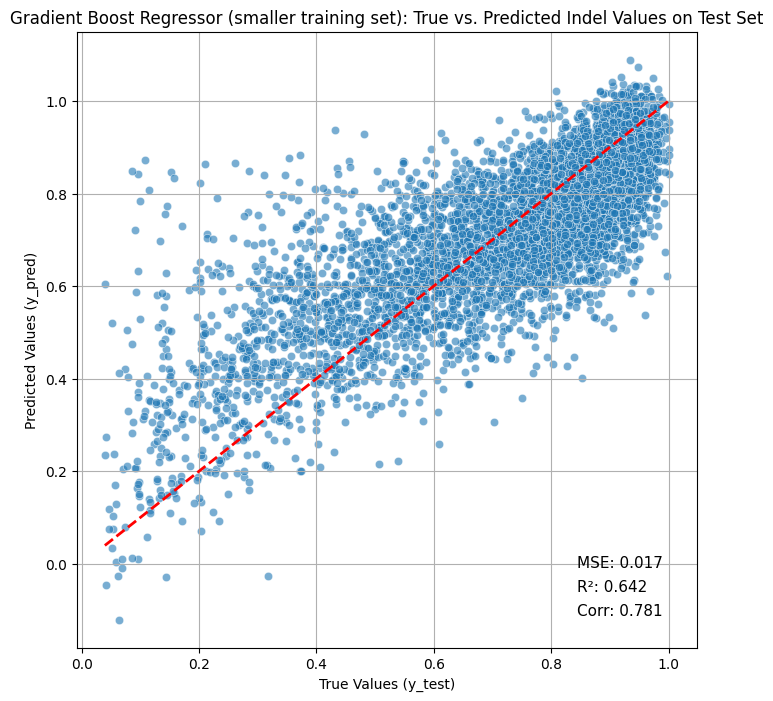

In [ ]:
mse_rf = mean_squared_error(y_test, y_pred_xgb)
r2_rf = r2_score(y_test, y_pred_xgb)
scorr_rf = spearmanr(y_test, y_pred_xgb).correlation

plot_prediction(y_test, y_pred_xgb, title='Gradient Boost Regressor (smaller training set): True vs. Predicted Indel Values on Test Set',
                r2=r2_rf,mse=mse_rf, scorr=scorr_rf)

In [ ]:
results_df = pd.DataFrame({'True_Value': y_test, 'Predicted_Value': y_pred_xgb}, index=y_test.index)

false_positive_data = results_df[
    (results_df['Predicted_Value'] > 0.6) &
    (results_df['True_Value'] < 0.4)
]

print(f"Number of data points where Predicted Value > 0.6 and True Value < 0.4: {len(false_positive_data)}")
print(false_positive_data.head())

Number of data points where Predicted Value > 0.6 and True Value < 0.4: 109
       True_Value  Predicted_Value
47133    0.393903         0.723407
31268    0.284127         0.759808
37780    0.152561         0.846939
37775    0.375635         0.621601
8761     0.285496         0.610892


Train XGB regressor with sp dataset

In [ ]:
sp_label = pd.concat([sp.drop('sgRNA', axis=1)/100, sp_split_encoded], axis=1)
sp_label.head()

,indel,4,5,6,7,8,9,10,11,12,...,15,16,17,18,19,20,21,22,23,24
0,0.242878,2,1,1,3,3,2,3,3,3,...,3,3,1,1,3,1,3,1,3,2
1,0.695004,1,1,3,3,1,0,2,1,3,...,2,3,2,0,1,0,2,3,2,0
2,0.259948,1,2,0,1,2,0,1,3,0,...,0,3,0,0,2,1,1,3,1,3
3,0.579646,1,0,0,0,1,3,2,0,1,...,0,2,0,0,1,1,3,3,2,3
4,0.393550,1,0,2,0,3,0,3,1,1,...,2,0,0,2,2,1,3,1,3,0


In [ ]:
X = sp_label.drop('indel', axis=1)
y = sp_label['indel']

y_binned = pd.cut(y, bins=10, labels=False, include_lowest=True)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_binned)

y_temp_binned = pd.cut(y_temp, bins=10, labels=False, include_lowest=True)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp_binned)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (10265, 21)
y_train shape: (10265,)
X_val shape: (1283, 21)
y_val shape: (1283,)
X_test shape: (1284, 21)
y_test shape: (1284,)


In [ ]:
X_train_np = X_train.values
X_test_np = X_test.values

X_train_one_hot = to_categorical(X_train_np, num_classes=4)
X_test_one_hot = to_categorical(X_test_np, num_classes=4)

X_train_one_hot = X_train_one_hot.reshape(X_train_one_hot.shape[0], -1)
X_test_one_hot = X_test_one_hot.reshape(X_test_one_hot.shape[0], -1)

print(f'X_train_one_hot shape: {X_train_one_hot.shape}')
print(f'X_test_one_hot shape: {X_test_one_hot.shape}')

X_train_one_hot shape: (10265, 84)
X_test_one_hot shape: (1284, 84)


In [ ]:
%%time
xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train_one_hot, y_train)

y_pred_xgb = xgb_model.predict(X_test_one_hot)

CPU times: user 640 ms, sys: 3.77 ms, total: 644 ms
Wall time: 330 ms


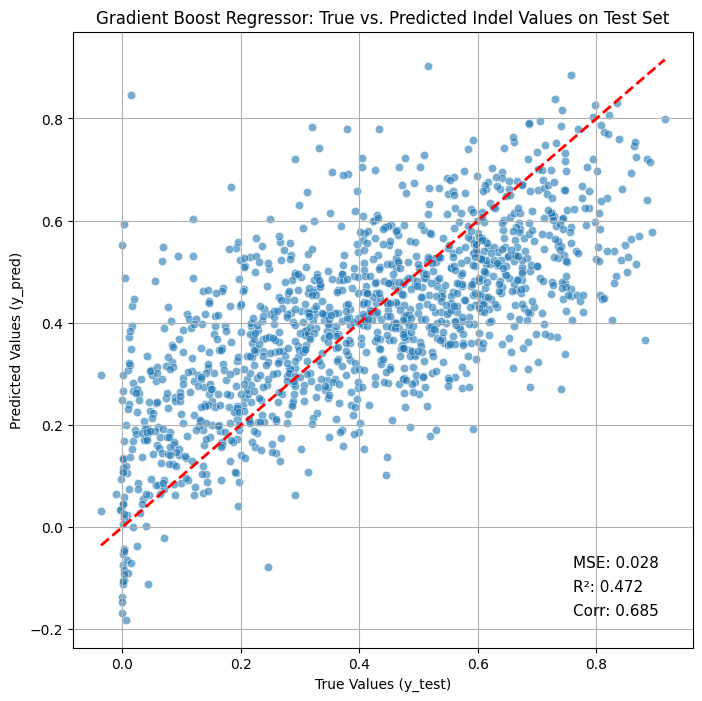

In [ ]:
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
scorr_xgb = spearmanr(y_test, y_pred_xgb).correlation

plot_prediction(y_test, y_pred_xgb, title='Gradient Boost Regressor: True vs. Predicted Indel Values on Test Set',
                r2=r2_xgb,mse=mse_xgb, scorr=scorr_xgb)

In [ ]:
results_df = pd.DataFrame({'True_Value': y_test, 'Predicted_Value': y_pred_xgb}, index=y_test.index)

false_positive_data = results_df[
    (results_df['Predicted_Value'] > 0.6) &
    (results_df['True_Value'] < 0.4)
]

print(f"Number of data points where Predicted Value > 0.6 and True Value < 0.4: {len(false_positive_data)}")
print(false_positive_data.head())

Number of data points where Predicted Value > 0.6 and True Value < 0.4: 16
       True_Value  Predicted_Value
12415    0.331209         0.742852
641      0.311127         0.655050
10958    0.395380         0.657901
122      0.380775         0.691382
1416     0.392961         0.618816
